In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# System and file operations
import os
import sys as SYS
SYS.path.insert(0, '../..')
import csv
from collections import defaultdict

import numpy as np
import pandas as pd
import h5py

from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.table import Table
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import networkx as nx

# Statistical plotting
import seaborn as sns

from src import setup
from src import (
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation,
    ket as ket
)

from Scripts import simulation_CLI as cleo
#pick={therm,inhomov1,inhomov2,greedy} pick one of these to properly store images with the correct tick_labels
dataset_label = "therm"

#Edited by ER: added these string definitions to the top, should follow through the whole code.
#Number of qubits
qubit_num=8
#Rule: greedy, random, landscape_maximizes, strongest_maximizes
order_rule_name = "random"
#System Connectivity, "cX_2local", note that if X = side-1, "cN_2local"
sys_connectivity = "cN_2local"
#Number of Trials
trial_num = 5

In [2]:
newdata = dict(h5py.File("../data/" + order_rule_name + "/" + order_rule_name + ".hdf5"))

In [3]:
def get_2_qbit_dms(data, n_qubits, connectivity, update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []

    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}

        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [4]:
twoQdms_allrules = get_2_qbit_dms(newdata, qubit_num, sys_connectivity, order_rule_name)

In [5]:
def extract_observables(two_qubit_dms, n_qubits):
    """
    Extract single-qubit σz expectation values and two-qubit correlations from density matrices.

    Args:
        two_qubit_dms: Array of shape (n_trials, n_timesteps, n_pairs) containing dictionaries
                       with two-qubit density matrices
        n_qubits: Number of qubits in the system

    Returns:
        sz: Array of shape (n_trials, n_timesteps, n_qubits) with σz expectation values
        corr: Array of shape (n_trials, n_timesteps, n_qubits, n_qubits) with σz-σz correlations
    """
    n_trials = two_qubit_dms.shape[0]
    n_timesteps = two_qubit_dms.shape[1]

    # Pauli Z matrix
    pauli_z = np.array([[1, 0], [0, -1]], dtype=complex)
    pauli_z_tensor = np.kron(pauli_z, pauli_z)

    # Initialize arrays as complex to avoid casting warnings
    sz = np.zeros((n_trials, n_timesteps, n_qubits), dtype=complex)
    corr = np.zeros((n_trials, n_timesteps, n_qubits, n_qubits), dtype=complex)

    # For each trial and timestep
    for trial in range(n_trials):
        for t in range(n_timesteps):
            # Count how many times each qubit appears to average properly
            counts = np.zeros(n_qubits)

            # For each qubit pair
            for pair, dm in two_qubit_dms[trial, t].items():
                i, j = pair

                # Get density matrix as numpy array
                rho = dm.data

                # Calculate local observables
                sz_i = np.trace(rho @ np.kron(pauli_z, np.eye(2, dtype=complex)))
                sz_j = np.trace(rho @ np.kron(np.eye(2, dtype=complex), pauli_z))

                # Calculate correlation
                corr_ij = np.trace(rho @ pauli_z_tensor) - sz_i * sz_j

                # Update counts
                counts[i] += 1
                counts[j] += 1

                # Update expectation values (will average later)
                sz[trial, t, i] += sz_i
                sz[trial, t, j] += sz_j

                # Store correlation
                corr[trial, t, i, j] = corr_ij
                corr[trial, t, j, i] = corr_ij

            # Average the expectation values
            for i in range(n_qubits):
                if counts[i] > 0:
                    sz[trial, t, i] /= counts[i]

    # Take real parts at the end - for Hermitian observables like Pauli-Z
    # the expectation values should be real, with any imaginary component
    # coming from numerical imprecision
    return sz.real, corr.real

    return sz, corr

In [6]:
def analyze_correlation_strength(corr):
    """
    Analyze the strength of correlations in the quantum system to determine
    appropriate thresholds.

    Args:
        corr: Array of shape (n_trials, n_timesteps, n_qubits, n_qubits) with correlations
             Can also be a tuple where the second element is the correlation array

    Returns:
        stats_dict: Dictionary with correlation statistics
        fig: Figure with correlation analysis plots
    """
    # Handle case where input might be a tuple from extract_observables
    if isinstance(corr, tuple) and len(corr) == 2:
        # Extract just the correlations (second element)
        corr = corr[1]

    # Get dimensions
    n_trials, n_timesteps, n_qubits, _ = corr.shape

    # Calculate correlation magnitudes (absolute values)
    corr_abs = np.abs(corr)

    # Average over trials
    avg_corr_abs = np.mean(corr_abs, axis=0)

    # Create mask to exclude self-correlations (diagonal elements)
    mask = ~np.eye(n_qubits, dtype=bool)
    mask_3d = np.broadcast_to(mask, (n_timesteps, n_qubits, n_qubits))

    # Extract off-diagonal elements for each time step
    off_diag_values = []
    for t in range(n_timesteps):
        off_diag_values.append(avg_corr_abs[t][mask])

    # Calculate statistics for each time step
    means = np.array([np.mean(vals) for vals in off_diag_values])
    medians = np.array([np.median(vals) for vals in off_diag_values])
    max_vals = np.array([np.max(vals) for vals in off_diag_values])
    percentile_75 = np.array([np.percentile(vals, 75) for vals in off_diag_values])
    percentile_90 = np.array([np.percentile(vals, 90) for vals in off_diag_values])

    # Calculate overall statistics
    overall_stats = {
        'mean': np.mean(means[250:]),
        'median': np.median(medians),
        'max': np.max(max_vals),
        'p75': np.mean(percentile_75),
        'p90': np.mean(percentile_90)
    }

    # Create recommended thresholds based on distribution
    recommended_thresholds = [
        overall_stats['p75'] * 0.5,  # Conservative threshold
        overall_stats['p75'],        # Moderate threshold
        overall_stats['p90']         # Stringent threshold
    ]

    # Round thresholds to 3 decimal places for clarity
    recommended_thresholds = [round(t, 3) for t in recommended_thresholds]

    # Determine correlation strength category
    if overall_stats['max'] < 0.1:
        strength_category = "Weak"
    elif overall_stats['max'] < 0.3:
        strength_category = "Moderate"
    else:
        strength_category = "Strong"

    # Create figure with multiple plots
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: Correlation magnitude distribution (histogram)
    plt.subplot(2, 2, 1)
    # Flatten all off-diagonal correlations from all time steps
    all_corrs = np.concatenate(off_diag_values)
    sns.histplot(all_corrs, bins=30, kde=True)

    # Add vertical lines for recommended thresholds
    for threshold in recommended_thresholds:
        plt.axvline(x=threshold, color='r', linestyle='--',
                   alpha=0.7, label=f'Threshold: {threshold:.3f}')

    plt.xlabel('Correlation Magnitude')
    plt.ylabel('Frequency')
    plt.title('Distribution of Correlation Magnitudes')
    plt.legend()

    # Plot 2: Correlation statistics over time
    plt.subplot(2, 2, 2)
    plt.plot(means, label='Mean')
    plt.plot(medians, label='Median')
    plt.plot(max_vals, label='Max')
    plt.plot(percentile_75, label='75th Percentile')
    plt.plot(percentile_90, label='90th Percentile')

    plt.xlabel('Time Step')
    plt.ylabel('Correlation Magnitude')
    plt.title('Correlation Statistics Over Time')
    plt.legend()

    # Plot 3: Box plot of correlation magnitudes at select time steps
    plt.subplot(2, 2, 3)
    # Select a subset of time steps for clarity
    time_indices = np.linspace(0, n_timesteps-1, min(10, n_timesteps), dtype=int)
    box_data = [off_diag_values[t] for t in time_indices]
    plt.boxplot(box_data, tick_labels=[f't={t}' for t in time_indices])
    plt.ylabel('Correlation Magnitude')
    plt.title('Correlation Distribution at Selected Time Steps')
    plt.xticks(rotation=45)

    # Plot 4: Heatmap of average correlation by distance and time
    plt.subplot(2, 2, 4)
    # Create simple distance matrix for 1D chain (can be replaced with actual distances)
    distances = np.zeros((n_qubits, n_qubits))
    for i in range(n_qubits):
        for j in range(n_qubits):
            distances[i, j] = abs(i - j)

    # Calculate average correlation by distance
    max_dist = int(np.max(distances))
    dist_corr = np.zeros((max_dist+1, n_timesteps))

    for d in range(1, max_dist+1):  # Skip d=0 (self correlations)
        mask_d = (distances == d)
        for t in range(n_timesteps):
            values = avg_corr_abs[t][mask_d]
            if len(values) > 0:
                dist_corr[d, t] = np.mean(values)

    # Plot heatmap
    im = plt.imshow(dist_corr[1:], aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(im, label='Average Correlation Magnitude')
    plt.xlabel('Time Step')
    plt.ylabel('Distance')
    plt.title('Average Correlation by Distance and Time')

    # Add text with overall statistics and recommendations
    plt.figtext(0.5, 0.01,
               f"Overall Correlation Strength: {strength_category}\n"
               f"Mean: {overall_stats['mean']:.3f} | Max: {overall_stats['max']:.3f} | "
               f"75th Percentile: {overall_stats['p75']:.3f} | 90th Percentile: {overall_stats['p90']:.3f}\n"
               f"Recommended Thresholds: {recommended_thresholds}",
               ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))


    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust for the figtext
    plt.savefig('Correlations_statistics_therm.png')

    # Prepare statistics dictionary for return
    stats_dict = {
        'overall': overall_stats,
        'by_time': {
            'mean': means,
            'median': medians,
            'max': max_vals,
            'p75': percentile_75,
            'p90': percentile_90
        },
        'strength_category': strength_category,
        'recommended_thresholds': recommended_thresholds
    }

    return stats_dict, fig

In [7]:
corr_allrules = extract_observables(twoQdms_allrules, 8)


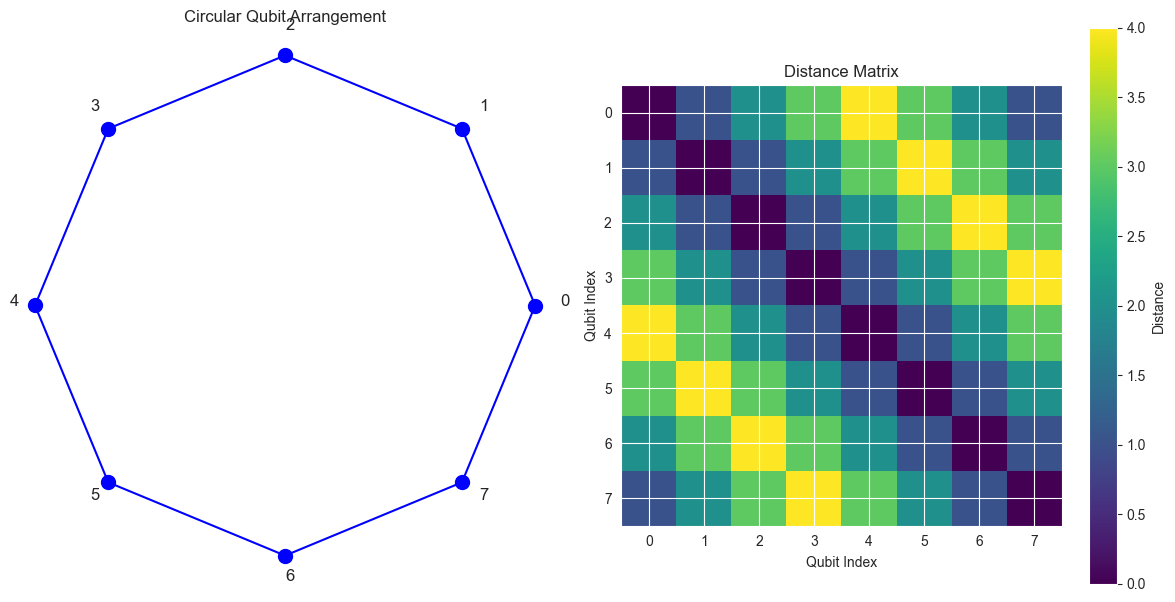

In [8]:
def create_circular_distances(n_qubits):
    """
    Creates a distance matrix for qubits arranged in a circle.

    For a circular arrangement, the distance between qubits i and j
    is the minimum of the clockwise and counterclockwise path lengths.

    Args:
        n_qubits: Number of qubits in the circle

    Returns:
        distances: Matrix of shape (n_qubits, n_qubits) with distances
    """
    distances = np.zeros((n_qubits, n_qubits))

    for i in range(n_qubits):
        for j in range(n_qubits):
            # Calculate shortest path on the circle
            direct_distance = abs(i - j)
            wraparound_distance = n_qubits - direct_distance
            distances[i, j] = min(direct_distance, wraparound_distance)

    return distances

def visualize_circular_connectivity(n_qubits, distances=None):
    """
    Visualize the circular qubit arrangement and optionally display
    the distance matrix.

    Args:
        n_qubits: Number of qubits in the circle
        distances: Optional distance matrix to display
    """
    fig, axes = plt.subplots(1, 2 if distances is not None else 1,
                            figsize=(12, 6) if distances is not None else (6, 6))

    if distances is not None:
        ax1, ax2 = axes
    else:
        ax1 = axes

    # Plot circular arrangement
    theta = np.linspace(0, 2*np.pi, n_qubits, endpoint=False)
    x = np.cos(theta)
    y = np.sin(theta)

    ax1.scatter(x, y, s=100, c='blue')

    # Add qubit tick_labels
    for i in range(n_qubits):
        ax1.text(x[i]*1.1, y[i]*1.1, f'{i}', fontsize=12)

    # Add connections between adjacent qubits
    for i in range(n_qubits):
        next_i = (i + 1) % n_qubits
        ax1.plot([x[i], x[next_i]], [y[i], y[next_i]], 'b-')

    ax1.set_title('Circular Qubit Arrangement')
    ax1.set_aspect('equal')
    ax1.axis('off')

    # Plot distance matrix if provided
    if distances is not None:
        im = ax2.imshow(distances, cmap='viridis')
        ax2.set_title('Distance Matrix')
        ax2.set_xlabel('Qubit Index')
        ax2.set_ylabel('Qubit Index')
        plt.colorbar(im, ax=ax2, label='Distance')

    plt.tight_layout()
    return fig

# Example usage:
n_qubits = 8
distances = create_circular_distances(n_qubits)
visualize_circular_connectivity(n_qubits, distances)
plt.show()

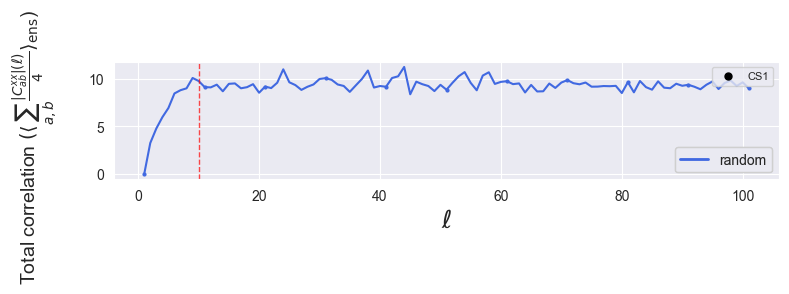

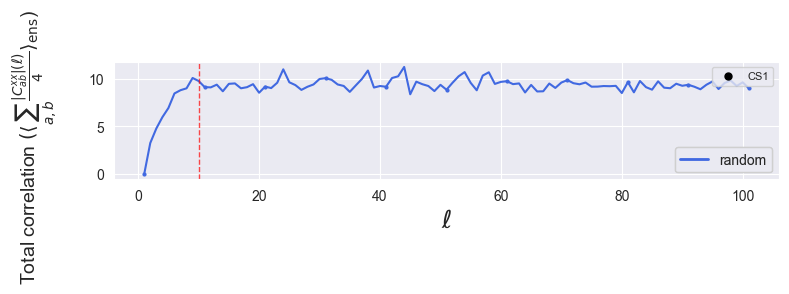

In [9]:
def plot_mean_correlation_sums(corrs_all_datas):
    dataset_labels = ["CS1"]
    markers = ["o"]
    rules = [order_rule_name]
    colors = ['#4169E1']

    fig, axes = plt.subplots(len(corrs_all_datas), 1, figsize=(8, 2*len(corrs_all_datas)))

    # Make axes iterable if there's only one subplot
    if len(corrs_all_datas) == 1:
        axes = [axes]

    for i, corr_per_ic in enumerate(corrs_all_datas):
        for j, corr_per_rule_in_ic in enumerate(corr_per_ic):
            # Get the correlation matrices for all trials
            trial_data = corr_per_rule_in_ic[1]

            # Number of time steps
            n_timesteps = len(trial_data[0])

            # Calculate mean sum for each time step across all trials
            mean_correlation_sums = []
            for t in range(n_timesteps):
                # Get the sum of absolute values for this time step across all trials
                step_sums = [np.sum(np.abs(trial[t])) for trial in trial_data]
                # Calculate the mean across all trials
                mean_correlation_sums.append(np.mean(step_sums))

            n_timesteps=101
            # Create time steps array
            x = np.arange(1, n_timesteps + 1)

            # Plot the mean sums
            axes[i].plot(x, mean_correlation_sums[0:200],
                        marker=markers[i], color=colors[j],
                        label=rules[j], markersize=2, markevery=10)

        # Add a vertical line at x=10 to each subplot
        axes[i].axvline(x=10, color='red', linestyle='--', linewidth=1, alpha=0.7)

        # Add dataset marker and label to upper right corner
        dataset_handle = plt.Line2D([0], [0], marker=markers[i], color='black',
                              markerfacecolor='black', markersize=5, linestyle='')
        dataset_legend = axes[i].legend([dataset_handle], [dataset_labels[i]],
                            loc='upper right', fontsize=8)
        axes[i].add_artist(dataset_legend)

        # Add rule legend at the bottom of each subplot
        rule_handles = [plt.Line2D([0], [0], color=colors[k], linewidth=2)
                     for k in range(len(rules))]
        rule_legend = axes[i].legend(handles=rule_handles, labels=rules,
                             loc='lower right', fontsize=10)
        axes[i].add_artist(rule_legend)

        # Add x-axis label only to the bottom subplot
        if i == len(corrs_all_datas) - 1:
            axes[i].set_xlabel(r'$\ell$', fontsize=18)

        # Remove y-axis label from individual subplots
        axes[i].set_ylabel('')

        axes[i].grid(True)

    # Add a single y-axis label for the entire figure
    fig.text(0.02, 0.5, r'Total correlation $(\langle \sum_{a,b} \frac{|C^{xx}_{ab}| (\ell)}{4}\rangle_{\rm ens}$)', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(left=0.15)

    #plt.savefig("Correlation_growth_8Q_all_rules_all_CS.png",dpi=300,bbox_inches="tight")
    # Adjust layout to make room for the y-axis label

    return fig

plot_mean_correlation_sums([[corr_allrules]])

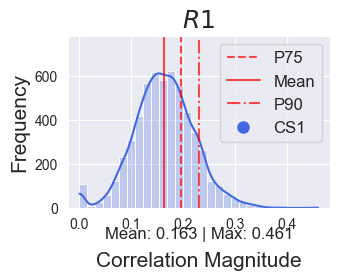

In [10]:
def plot_multiple_correlation_distributions(correlation_datasets, labels, colors, bins=30):
    """
    Plot correlation magnitude distributions for multiple datasets in a single row
    with square-like aspect ratio for each plot.

    Args:
        correlation_datasets: List of correlation arrays or tuples
        labels: List of labels for each dataset
        colors: List of colors for each dataset
        bins: Number of histogram bins (default: 30)

    Returns:
        fig: The figure object
        stats_dict: Dictionary with correlation statistics for each dataset
    """
    # Calculate figure size based on number of datasets to maintain square plots
    n_datasets = len(correlation_datasets)
    # Height of 4, width scales with number of datasets (3.5 per dataset)
    figsize = (6, 7)

    # Create figure
    fig, axes = plt.subplots(1, n_datasets, figsize=figsize)

    # Handle case of single dataset
    if n_datasets == 1:
        axes = [axes]

    # Container for statistics
    stats_dict = {}

    # Process each dataset
    for i, corr_data in enumerate(correlation_datasets):
        # Handle case where input might be a tuple
        if isinstance(corr_data, tuple) and len(corr_data) >= 2:
            corr = corr_data[1]  # Extract correlations
        else:
            corr = corr_data

        # Get dimensions
        if len(corr.shape) == 4:
            n_trials, n_timesteps, n_qubits, _ = corr.shape
        else:
            # Handle case where there might not be multiple trials
            n_timesteps, n_qubits, _ = corr.shape
            n_trials = 1
            corr = corr.reshape(1, n_timesteps, n_qubits, n_qubits)

        # Calculate correlation magnitudes (absolute values)
        corr_abs = np.abs(corr)

        # Average over trials
        avg_corr_abs = np.mean(corr_abs, axis=0)

        # Create mask to exclude self-correlations (diagonal elements)
        mask = ~np.eye(n_qubits, dtype=bool)
        mask_3d = np.broadcast_to(mask, (n_timesteps, n_qubits, n_qubits))

        # Extract off-diagonal elements for each time step
        off_diag_values = []
        for t in range(n_timesteps):
            off_diag_values.append(avg_corr_abs[t][mask])

        # Calculate statistics
        means = np.array([np.mean(vals) for vals in off_diag_values])
        medians = np.array([np.median(vals) for vals in off_diag_values])
        max_vals = np.array([np.max(vals) for vals in off_diag_values])
        percentile_75 = np.array([np.percentile(vals, 75) for vals in off_diag_values])
        percentile_90 = np.array([np.percentile(vals, 90) for vals in off_diag_values])

        # Calculate overall statistics
        overall_stats = {
            'mean': np.mean(means),
            'median': np.median(medians),
            'max': np.max(max_vals),
            'p75': np.mean(percentile_75),
            'p90': np.mean(percentile_90)
        }

        # Create recommended thresholds
        recommended_thresholds = [
            overall_stats['p75'],  # Conservative
            overall_stats['mean'],        # Moderate
            overall_stats['p90']         # Stringent
        ]

        # Round thresholds for clarity
        recommended_thresholds = [round(t, 3) for t in recommended_thresholds]

        # Store statistics for this dataset
        stats_dict[labels[i]] = {
            'overall': overall_stats,
            'by_time': {
                'mean': means,
                'median': medians,
                'max': max_vals,
                'p75': percentile_75,
                'p90': percentile_90
            },
            'recommended_thresholds': recommended_thresholds
        }

        # Flatten all off-diagonal correlations from all time steps for plotting
        all_corrs = np.concatenate(off_diag_values)

        # Plot histogram with KDE
        sns.histplot(all_corrs, bins=bins, kde=True, color=colors[i], alpha=0.25, ax=axes[i])

        # Add vertical lines for recommended thresholds
        for j, threshold in enumerate(recommended_thresholds):
            linestyle = ['--', '-', '-.'][j % 3]
            axes[i].axvline(x=threshold, color='r', linestyle=linestyle,
                          alpha=0.7, label=f'Threshold: {threshold:.3f}')

        # Set labels and title
        axes[i].set_xlabel('Correlation Magnitude')
        if i == 0:  # Only add y-label to the first plot
            axes[i].set_ylabel('Frequency')
        else:
            axes[i].set_ylabel('')  # Remove y-labels from other plots

        axes[i].set_title(f'{labels[i]}')

        # Make the plot more square by adjusting y-limits
        # Get current y-limit
        y_max = axes[i].get_ylim()[1]
        # Set a reasonable y-limit to make plots more square
        axes[i].set_ylim(0, y_max * 1.2)

        # Add stats below the plot
        stats_text = (f"Mean: {overall_stats['mean']:.3f} | "
                     f"Median: {overall_stats['median']:.3f} | "
                     f"Max: {overall_stats['max']:.3f}")

        thresholds_text = (f"Thresholds: {recommended_thresholds[0]:.3f}, "
                          f"{recommended_thresholds[1]:.3f}, "
                          f"{recommended_thresholds[2]:.3f}")

        axes[i].annotate(stats_text, xy=(0.5, -0.15), xycoords='axes fraction',
                       ha='center', va='center', fontsize=9)

        axes[i].annotate(thresholds_text, xy=(0.5, -0.25), xycoords='axes fraction',
                       ha='center', va='center', fontsize=9)

    #plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # Add space at the bottom for annotations

    return fig, stats_dict


# Create a new function to plot all ICs at once in a grid
def plot_all_correlations_grid(ic_all_datas, corrs_all_datas, colors=None):
    """
    Plot all correlation datasets in a grid, with each row corresponding to an IC type
    and each column to a different rule.

    Args:
        ic_all_datas: List of IC types
        corrs_all_datas: 2D list of correlation datasets (rows=IC types, cols=rules)
        colors: List of colors for each rule

    Returns:
        fig: The figure object
    """
    n_ics = len(ic_all_datas)
    n_rules = len(corrs_all_datas[0]) if corrs_all_datas and corrs_all_datas[0] else 1

    if colors is None:
        colors = ['#4169E1']
    markers = ['o']  # circle, diamond, triangle, square
    labels=["CS1"]

    # Create a larger figure for the grid
    fig, axes = plt.subplots(n_ics, n_rules, figsize=(n_rules * 3.5, n_ics * 3.5))

    # Handle the case where we have only one subplot
    if n_ics == 1 and n_rules == 1:
        axes = np.array([[axes]])  # Make it 2D
    elif n_ics == 1:
        axes = axes.reshape(1, -1)  # Make it 2D with one row
    elif n_rules == 1:
        axes = axes.reshape(-1, 1)  # Make it 2D with one column

    #Max y per row
    max_ylims = [0] * n_ics

    # Define rule names
    rule_names = [f'R{i+1}' for i in range(n_rules)]

    # Container for statistics
    all_stats = {}

    # Process each IC type and rule
    for i, (IC, corr_row) in enumerate(zip(ic_all_datas, corrs_all_datas)):
        for j, corr_data in enumerate(corr_row):
            # Process this specific correlation dataset

            # Handle case where input might be a tuple
            if isinstance(corr_data, tuple) and len(corr_data) >= 2:
                corr = corr_data[1]  # Extract correlations
            else:
                corr = corr_data

            # Get dimensions
            if len(corr.shape) == 4:
                n_trials, n_timesteps, n_qubits, _ = corr.shape
            else:
                # Handle case where there might not be multiple trials
                n_timesteps, n_qubits, _ = corr.shape
                n_trials = 1
                corr = corr.reshape(1, n_timesteps, n_qubits, n_qubits)

            # Calculate correlation magnitudes (absolute values)
            corr_abs = np.abs(corr)

            # Average over trials
            avg_corr_abs = np.mean(corr_abs, axis=0)

            # Create mask to exclude self-correlations (diagonal elements)
            mask = ~np.eye(n_qubits, dtype=bool)
            mask_3d = np.broadcast_to(mask, (n_timesteps, n_qubits, n_qubits))

            # Extract off-diagonal elements for each time step
            off_diag_values = []
            for t in range(n_timesteps):
                off_diag_values.append(avg_corr_abs[t][mask])

            # Calculate statistics
            means = np.array([np.mean(vals) for vals in off_diag_values])
            medians = np.array([np.median(vals) for vals in off_diag_values])
            max_vals = np.array([np.max(vals) for vals in off_diag_values])
            percentile_75 = np.array([np.percentile(vals, 75) for vals in off_diag_values])
            percentile_90 = np.array([np.percentile(vals, 90) for vals in off_diag_values])

            # Calculate overall statistics
            overall_stats = {
                'mean': np.mean(means),
                'median': np.median(medians),
                'max': np.max(max_vals),
                'p75': np.mean(percentile_75),
                'p90': np.mean(percentile_90)
            }

            # Create recommended thresholds
            recommended_thresholds = [
                overall_stats['p75'] ,
                overall_stats['mean'],        # Moderate
                overall_stats['p90']         # Stringent
            ]

            # Round thresholds for clarity
            recommended_thresholds = [round(t, 3) for t in recommended_thresholds]

            # Store statistics
            key = f"{IC}_{rule_names[j]}"
            all_stats[key] = {
                'overall': overall_stats,
                'recommended_thresholds': recommended_thresholds
            }

            # Flatten all off-diagonal correlations from all time steps for plotting
            all_corrs = np.concatenate(off_diag_values)

            # Plot histogram with KDE
            sns.histplot(all_corrs, bins=30, kde=True, color=colors[j], alpha=0.25, ax=axes[i, j])

            # Add vertical lines for recommended thresholds
            for k, threshold in enumerate(recommended_thresholds):
                linestyle = ['--', '-', '-.'][k % 3]
                threshold_key=["P75","Mean","P90"]
                if (i,j) == (0,0):
                    axes[i, j].axvline(x=threshold, color='r', linestyle=linestyle,
                              alpha=0.7, label=f'{threshold_key[k]}')
                else:
                    axes[i, j].axvline(x=threshold, color='r', linestyle=linestyle,
                              alpha=0.7, label='')

            # Don't call legend() here - we'll combine all elements later

            # Create label with proper superscripts/subscripts
            label = f'$R{j+1}$'
            if i == 3:
                legend_label = f'CSP'
            else:
                legend_label = f'CS{i+1}'

            # Set labels and title
            if i == n_ics - 1:  # Only add x-label to the bottom row
                axes[i, j].set_xlabel('Correlation Magnitude', fontsize=15)
                axes[i, j].xaxis.set_label_coords(0.5, -0.25)
            else:
                axes[i, j].set_xlabel('')

            if j == 0:  # Only add y-label to the first column
                axes[i, j].set_ylabel(f'Frequency', fontsize=15)
            else:
                axes[i, j].set_ylabel('')

            if i == 0:
                axes[i, j].set_title(label, fontsize=18)
            else:
                axes[i, j].set_xlabel('')

            # Create custom handle for scatter plot legend
            custom_handle = Line2D([0], [0], marker=markers[i], color=colors[j],
                             markersize=8, linestyle='None')

            # Get current handles and labels from threshold lines
            handles, labels_list = axes[i, j].get_legend_handles_labels()

            # Add custom handle to handles list
            handles.append(custom_handle)

            # Add custom label to labels list
            labels_list.append(legend_label)

            # Now create a single legend with all elements
            axes[i, j].legend(handles=handles, labels=labels_list,
                      loc='upper right', fontsize=12)

            y_max = axes[i, j].get_ylim()[1]
            max_ylims[i] = max(max_ylims[i], y_max)

            # Make the plot more square by adjusting y-limits
            # Get current y-limit
            #y_max = axes[i, j].get_ylim()[1]
            # Set a reasonable y-limit to make plots more square

            # Add stats below the plot
            stats_text = (f"Mean: {overall_stats['mean']:.3f} | "
                         f"Max: {overall_stats['max']:.3f}")

            #thresholds_text = (f"Thresholds: {recommended_thresholds[1]:.3f}")

            # Use smaller font size for the annotations due to the grid layout
            axes[i, j].annotate(stats_text, xy=(0.5, -0.15), xycoords='axes fraction',
                           ha='center', va='center', fontsize=12)

            #axes[i, j].annotate(thresholds_text, xy=(0.5, -0.25), xycoords='axes fraction',
             #             ha='center', va='center', fontsize=8)

    # Adjust layout with room for annotations
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    for i in range(n_ics):
        # Find maximum y-limit in this row
        row_max = max(axes[i, j].get_ylim()[1] for j in range(n_rules))
        # Apply to all plots in the row
        for j in range(n_rules):
            axes[i, j].set_ylim(0, row_max * 1.2)

    return fig, all_stats


ic_all_datas = ['IC_{th}']
corrs_all_datas = [[corr_allrules]]

# Define colors for each rule
colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#8A2BE2']

# Plot all data in a single grid
fig, all_stats = plot_all_correlations_grid(ic_all_datas, corrs_all_datas, colors)

# Save the figure
# plt.savefig('all_correlation_distributions_grid_12q_c4.png', dpi=300 ,bbox_inches='tight')
plt.show()

In [11]:
def mutual_info_dicts(twoQdms, trial_index):
    mutual_info_list = []
    for time_step in twoQdms[trial_index]:
        mutual_info_dict = {}
        mutual_info = measure.mutual_information_of_every_pair_dict(time_step)
        # Filter out values below the precision threshold
        filtered_mutual_info = {k: v if v >= 1e-6 else 0 for k, v in mutual_info.items()}
        # Update the mutual_info_dict with the filtered mutual info for the current time step
        mutual_info_dict.update(filtered_mutual_info)
        # Append the mutual_info_dict to the list
        mutual_info_list.append(mutual_info_dict)
    return mutual_info_list
# Call the two_point_dict function for each trial index
# Get the list of dictionaries containing two point values for each time step
def create_adjacency_matrix_two_dim(two_point_dict, num_nodes):
    adjacency_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for (node1, node2), two_point_value in two_point_dict.items():
        adjacency_matrix[node1][node2] = two_point_value
        adjacency_matrix[node2][node1] = two_point_value  # Assuming undirected graph
    return adjacency_matrix
def adjacency_matrices_list_two_dim(twoQdms, trial_index, num_nodes, two_point_dicts):
    # Get the list of dictionaries containing mutual information values for each time step
    two_point_dicts_list = two_point_dicts(twoQdms, trial_index)
    # Create adjacency matrices for each time step
    adjacency_matrices = []
    for two_point_dict in two_point_dicts_list:
        adj_matrix = create_adjacency_matrix_two_dim(two_point_dict, num_nodes)
        adjacency_matrices.append(adj_matrix)
    return adjacency_matrices

def compute_averaged_matrix(matrix_list):

    # Sum all matrices element-wise
    summed_matrix = np.sum(matrix_list, axis=0)

    # Compute the average by dividing by the number of matrices (time steps)
    time_avg_matrix = summed_matrix / len(matrix_list)

    return time_avg_matrix
#Time average value for each qubit
def time_averaged_one_point_measures_at_t(dataset,t):
    # Assuming dataset is list of 100 lists i.e. one trial
    #stack datasets in 3D
    # Take the ensemble average along the first axis (averaging over all datasets)
    sum_till_t = np.sum(dataset[:t], axis=0)
    time_average_t = (1/(t+1))*(sum_till_t)
    return (time_average_t)

def time_averaged_one_point_measures_matrix_full_sim(dataset):
    # Take the ensemble average along the first axis (averaging over all datasets)
    time_average=[]
    for t in range(len(dataset)):
        time_average.append(time_averaged_one_point_measures_at_t(dataset,t))
    return (time_average)
def generate_all_adjacency_matrices(twoQdms, num_seeds, num_qubits, mutual_info_dicts):
    # Initialize an empty list to store the adjacency matrices for each trial
    all_trials_adjacency_matrices = []

    # Loop over each seed from 0 to num_seeds-1
    for seed in range(num_seeds):
        # Generate an empty list to store adjacency matrices for this trial
        trial_matrices = []

        # Generate the adjacency matrix for the given seed
        adj_matrix = adjacency_matrices_list_two_dim(twoQdms, seed, num_qubits, mutual_info_dicts)

        # Append each generated adjacency matrix to the trial-specific list
        trial_matrices.append(adj_matrix)

        # Append the list of matrices for this trial to the overall list
        all_trials_adjacency_matrices.append(trial_matrices)

    # Convert to a NumPy array if needed
    all_trials_adjacency_matrices_array = np.array(all_trials_adjacency_matrices)

    return all_trials_adjacency_matrices_array


def ensemble_avg_list(data):
    ensemble_avg_list = []

    # Loop through each time step
    for t in range(499):
        matrix_at_t_diff_trials=[]
        for seed in range(99):
            matrix_at_t_diff_trials.append(data[seed][0][t])
        # Calculate the average adjacency matrix for this time step
        avg_matrix_at_t = np.mean(matrix_at_t_diff_trials, axis=0)
        # Append the averaged matrix to the ensemble list
        ensemble_avg_list.append(avg_matrix_at_t)
    return ensemble_avg_list

#Total Mutual information on the network. This serves as a measure compared to the maximum mutual information that can develop on network
def MItotal(MI_adj):
    MI_adj_tot=[]
    for i in range(499):
       MI_adj_tot.append(np.sum(MI_adj[i],axis=0))
    return np.array(MI_adj_tot)

In [12]:
#Edit by ER: size=8; num_seeds=5; num_qubits=8, already defined

#MI_adj_greedy_c2_th=adjacency_matrices_list_two_dim(twoQdmsgreedyc2,seed,size, mutual_info_dicts)
#MI_adj_greedy_c2_th=adjacency_matrices_list_two_dim(twoQdmsgreedyc2,seed,size, mutual_info_dicts)
#MI_adj_mimic_c2_th=adjacency_matrices_list_two_dim(twoQdmsmimicc2,seed,size, mutual_info_dicts)
#MI_adj_landmax_c2_th=adjacency_matrices_list_two_dim(twoQdmslandmaxc2_th,seed,size, mutual_info_dicts)
#MI_adj_strongmax_c2_th=adjacency_matrices_list_two_dim(twoQdmsstrongmax2_th,seed,size, mutual_info_dicts)

MI_adj = generate_all_adjacency_matrices(twoQdms_allrules, trial_num, qubit_num, mutual_info_dicts)


/Users/elliottrose/Documents/GitHub/QuNet/QuNet_bootcamp_2025/Session_3/../../src/measurements.py:171: RuntimeWarning: divide by zero encountered in log
  from_eigen = -np.sum(eigen_vals * np.log(eigen_vals))
/Users/elliottrose/Documents/GitHub/QuNet/QuNet_bootcamp_2025/Session_3/../../src/measurements.py:171: RuntimeWarning: invalid value encountered in multiply
  from_eigen = -np.sum(eigen_vals * np.log(eigen_vals))
/Users/elliottrose/Documents/GitHub/QuNet/QuNet_bootcamp_2025/Session_3/../../src/measurements.py:181: RuntimeWarning: divide by zero encountered in log
  -a1 * np.log(a1) +
/Users/elliottrose/Documents/GitHub/QuNet/QuNet_bootcamp_2025/Session_3/../../src/measurements.py:181: RuntimeWarning: invalid value encountered in scalar multiply
  -a1 * np.log(a1) +
/Users/elliottrose/Documents/GitHub/QuNet/QuNet_bootcamp_2025/Session_3/../../src/measurements.py:182: RuntimeWarning: divide by zero encountered in log
  -d4 * np.log(d4) +
/Users/elliottrose/Documents/GitHub/QuNet/QuN

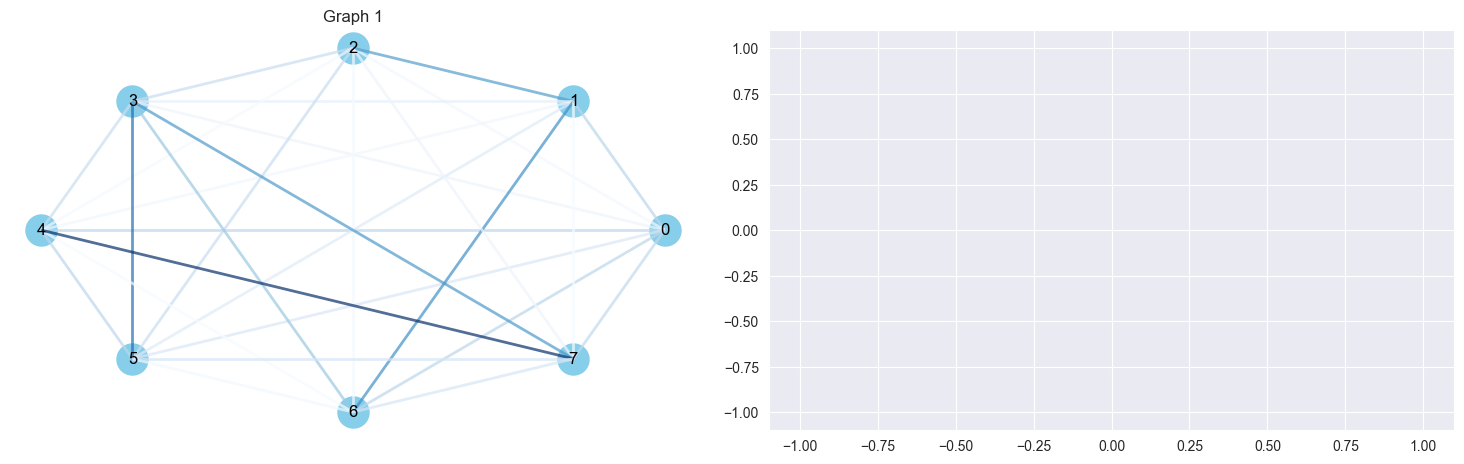

<Figure size 640x480 with 0 Axes>

In [13]:
n=100
#trial number
m=2

# Example: four different datasets of node pairs (replace with your real data)
#datasets = np.array([MI_adj_greedy_cn[490], MI_adj_greedy_cn[490], MI_adj_mimic_cn[490], MI_adj_landmax_cn[490]]) #MI_adj_landmax[99]]) # Replace these with your actual datasets
datasets = np.array([MI_adj[m][0][n]]) #MI_adj_landmax[99]]) # Replace these with your actual datasets
dataset_titles = [order_rule_name + " MI"]

G1 = nx.from_numpy_array(datasets[0])


# Function to draw graph with consistent coloring and uniform thickness
def draw_graph_with_consistent_weights(G, pos, title, ax, vmin, vmax, cmap_name='Blues'):
    # Get the edge weights
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    # Get edges and weights in correct order
    edgelist = list(G.edges())
    weights = []
    for u, v in edgelist:
        if (u, v) in edge_weights:
            weights.append(edge_weights[(u, v)])
        else:
            weights.append(edge_weights.get((v, u), 1.0))

    # Use a constant line width for all edges
    constant_width = 2.0

    # Draw edges with color based on weights, but uniform thickness
    cmap = mpl.colormaps[cmap_name]
    edge_colors = [cmap((w - vmin) / (vmax - vmin) if vmax > vmin else 0.5) for w in weights]

    # Create edge collection manually
    edge_pos = np.asarray([(pos[e[0]], pos[e[1]]) for e in edgelist])

    # Draw the edges
    line_segments = []
    for (x1, y1), (x2, y2) in edge_pos:
        line_segments.append([(x1, y1), (x2, y2)])

    from matplotlib.collections import LineCollection
    lc = LineCollection(line_segments, colors=edge_colors, linewidths=constant_width, alpha=0.7)
    ax.add_collection(lc)

    ax.set_title(title)
    ax.axis('off')

    return lc

# Find global min and max weights across all graphs
all_weights = []
for G in [G1]:
    weights = list(nx.get_edge_attributes(G, 'weight').values())
    all_weights.extend(weights)

vmin = min(all_weights)
vmax = max(all_weights)

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

# Set axis limits for all subplots
for ax in axes:
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

# Draw each graph with consistent scale
pos = nx.circular_layout(G1)  # Use consistent layout
edges1 = draw_graph_with_consistent_weights(G1, pos, "Graph 1", axes[0], vmin, vmax)
#edges2 = draw_graph_with_consistent_weights(G2, pos, "Graph 2", axes[1], vmin, vmax)
#edges3 = draw_graph_with_consistent_weights(G3, pos, "Graph 3", axes[2], vmin, vmax)
##edges4 = draw_graph_with_consistent_weights(G4, pos, "Graph 4", axes[3], vmin, vmax)
#edges5 = draw_graph_with_consistent_weights(G5, pos, "Graph 5", axes[4], vmin, vmax)


# Add a common colorbar
cmap = mpl.colormaps['RdBu']  # Updated to use the new method
sm = ScalarMappable(norm=Normalize(vmin, vmax), cmap=cmap)
sm.set_array([])
#cbar = fig.colorbar(sm, ax=axes, label='Edge Weight', orientation='vertical', fraction=0.046, pad=0.04)

# Use fig.tight_layout() with a larger pad to prevent the warning
fig.tight_layout(pad=2.0)
plt.show()

# For the combined graph
#plt.figure(figsize=(10, 8))
#ax = plt.gca()
#ax.set_xlim(-1.1, 1.1)
#ax.set_ylim(-1.1, 1.1)
#combined_graph = nx.compose_all([G1, G2, G3, G4,G5])
#edges = draw_graph_with_consistent_weights(combined_graph, pos, "Combined Graph", ax, vmin, vmax)

# Add colorbar for combined graph
sm = ScalarMappable(norm=Normalize(vmin, vmax), cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Edge Weight')

plt.tight_layout(pad=2.0)
plt.show()

In [14]:
def clustering_coeff(adjacency_matrix_list):
    C_list = []
    for adj_mat in adjacency_matrix_list:
        adj_mat = np.array(adj_mat)
        M_sq = adj_mat @ adj_mat
        sum_of_M_sq = np.sum(M_sq)
        M_cube = adj_mat @ adj_mat @ adj_mat
        M_cube_trace = np.trace(M_cube)
        if sum_of_M_sq == 0:
            C_list.append(0)
        else:
            C_list.append(M_cube_trace / sum_of_M_sq)
    return np.array(C_list)

def disparity_function(adjacency_matrix_list, N):
    D_list = []
    for adj_mat in adjacency_matrix_list:
        M_row_sum_squared = np.sum(adj_mat, axis=1)**2
        M_row_sum_of_squared_elements = np.sum(adj_mat**2, axis=1)
        # Check for zero division before performing division
        Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)
        D_list.append(np.sum(Di) / N)
    return np.array(D_list)

# Function to calculate node-level metrics
def node_level_metrics(adj_mat):
    """Calculate node-level clustering and disparity for a given adjacency matrix"""
    n_nodes = adj_mat.shape[0]

    # Node-level clustering
    node_clustering = np.zeros(n_nodes)
    # Node-level disparity
    node_disparity = np.zeros(n_nodes)

    for i in range(n_nodes):
        # For node clustering, we need to calculate the local clustering coefficient
        neighbors = np.where(adj_mat[i] > 0)[0]
        if len(neighbors) >= 2:
            # Extract the subgraph of neighbors
            subgraph = adj_mat[np.ix_(neighbors, neighbors)]
            # Calculate clustering for this node (triangles / possible triangles)
            possible_connections = len(neighbors) * (len(neighbors) - 1) / 2
            if possible_connections > 0:
                actual_connections = np.sum(subgraph) / 2  # Divide by 2 for undirected graph
                node_clustering[i] = actual_connections / possible_connections
            else:
                node_clustering[i] = 0
        else:
            node_clustering[i] = 0

        # For node disparity
        row_sum = np.sum(adj_mat[i])
        if row_sum > 0:
            node_disparity[i] = np.sum((adj_mat[i] / row_sum) ** 2)
        else:
            node_disparity[i] = 0

    return node_clustering, node_disparity

# Function to analyze multiple temporal networks
def analyze_multiple_temporal_networks(network_list, network_names=None):
    """
    Analyze multiple temporal networks and provide comparative metrics and visualizations

    Parameters:
    network_list: list of lists of adjacency matrices, each inner list represents time evolution of one network
    network_names: optional list of names for networks

    Returns:
    Dictionary of metrics and produces visualizations
    """
    n_networks = len(network_list)

    if network_names is None:
        network_names = [f"Network {i+1}" for i in range(n_networks)]

    # Data structures to store results
    avg_adjacency_matrices = []  # Time-averaged matrices
    global_metrics = {
        'avg_clustering': [],    # Clustering of time-averaged matrix
        'mean_clustering': [],   # Mean of per-timestep clustering
        'avg_disparity': [],     # Disparity of time-averaged matrix
        'mean_disparity': []     # Mean of per-timestep disparity
    }

    # Calculate metrics for each network
    for net_idx, time_matrices in enumerate(network_list):
        n_timepoints = len(time_matrices)
        n_nodes = time_matrices[0].shape[0]

        # Calculate metrics at each time step
        clustering_per_time = []
        disparity_per_time = []

        for t in range(n_timepoints):
            adj_mat = time_matrices[t]
            clustering_per_time.append(clustering_coeff([adj_mat])[0])
            disparity_per_time.append(disparity_function([adj_mat], n_nodes)[0])

        # Calculate time-averaged matrix
        avg_adj_mat = np.mean(time_matrices, axis=0)
        avg_adjacency_matrices.append(avg_adj_mat)

        # Calculate metrics on time-averaged matrix
        avg_clustering = clustering_coeff([avg_adj_mat])[0]
        avg_disparity = disparity_function([avg_adj_mat], n_nodes)[0]

        # Store metrics
        global_metrics['avg_clustering'].append(avg_clustering)
        global_metrics['mean_clustering'].append(np.mean(clustering_per_time))
        global_metrics['avg_disparity'].append(avg_disparity)
        global_metrics['mean_disparity'].append(np.mean(disparity_per_time))

    # Calculate node-level metrics for time-averaged matrices
    node_metrics = []
    for net_idx, avg_adj_mat in enumerate(avg_adjacency_matrices):
        node_clustering, node_disparity = node_level_metrics(avg_adj_mat)
        node_metrics.append({
            'node_clustering': node_clustering,
            'node_disparity': node_disparity,
            'node_clustering_mean': np.mean(node_clustering),
            'node_clustering_std': np.std(node_clustering),
            'node_disparity_mean': np.mean(node_disparity),
            'node_disparity_std': np.std(node_disparity)
        })

    # Create table of global metrics
    global_metrics_df = pd.DataFrame({
        'Network': network_names,
        'Time-Avg Clustering': [f"{x:.6f}" for x in global_metrics['avg_clustering']],
        'Mean Timestep Clustering': [f"{x:.6f}" for x in global_metrics['mean_clustering']],
        'Time-Avg Disparity': [f"{x:.6f}" for x in global_metrics['avg_disparity']],
        'Mean Timestep Disparity': [f"{x:.6f}" for x in global_metrics['mean_disparity']]
    })

    # Create table of node-level metrics
    node_metrics_df = pd.DataFrame({
        'Network': network_names,
        'Node Clustering Mean': [f"{x['node_clustering_mean']:.6f}" for x in node_metrics],
        'Node Clustering Std': [f"{x['node_clustering_std']:.6f}" for x in node_metrics],
        'Node Disparity Mean': [f"{x['node_disparity_mean']:.6f}" for x in node_metrics],
        'Node Disparity Std': [f"{x['node_disparity_std']:.6f}" for x in node_metrics]
    })

    # Create visualizations
    # First, plot the table of metrics
    plt.figure(figsize=(12, 4))
    plt.title("Network Metrics Comparison", fontsize=14)
    ax = plt.subplot(111)
    ax.axis('off')

    table = ax.table(
        cellText=global_metrics_df.values,
        colLabels=global_metrics_df.columns,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.tight_layout()
    plt.show()

    # Second, show node-level metrics
    plt.figure(figsize=(12, 4))
    plt.title("Node-Level Metrics", fontsize=14)
    ax = plt.subplot(111)
    ax.axis('off')

    table = ax.table(
        cellText=node_metrics_df.values,
        colLabels=node_metrics_df.columns,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.tight_layout()
    plt.show()

    # Third, plot network visualizations and histograms
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(2, 5, figure=fig)

    # Function to draw network
    def draw_network(G, ax, title, cmap_name='viridis'):
        pos = nx.circular_layout(G)
        edge_weights = nx.get_edge_attributes(G, 'weight')

        # Find min/max for color normalization
        vmin = min(edge_weights.values()) if edge_weights else 0
        vmax = max(edge_weights.values()) if edge_weights else 1

        # Draw nodes and labels
        nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=300, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

        # Get edges and weights in correct order
        edgelist = list(G.edges())
        weights = [edge_weights[e] for e in edgelist]

        # Use a constant line width
        constant_width = 2.0

        # Draw edges with color based on weights
        cmap = mpl.colormaps[cmap_name]

        # Handle empty graphs
        if vmax > vmin:
            edge_colors = [cmap((w - vmin) / (vmax - vmin)) for w in weights]
        else:
            edge_colors = [cmap(0.5) for _ in weights]

        # Create edge collection manually
        edge_pos = np.asarray([(pos[e[0]], pos[e[1]]) for e in edgelist])

        # Draw the edges
        line_segments = []
        for (x1, y1), (x2, y2) in edge_pos:
            line_segments.append([(x1, y1), (x2, y2)])

        from matplotlib.collections import LineCollection
        if line_segments:  # Only create LineCollection if there are edges
            lc = LineCollection(line_segments, colors=edge_colors, linewidths=constant_width, alpha=0.7)
            ax.add_collection(lc)

        ax.set_title(title, fontsize=10)
        ax.axis('off')

    # Plot network visualizations in top row
    for idx, avg_adj_mat in enumerate(avg_adjacency_matrices):
        ax = fig.add_subplot(gs[0, idx])
        G = nx.from_numpy_array(avg_adj_mat)
        draw_network(G, ax, f"{network_names[idx]}\nC={global_metrics['avg_clustering'][idx]:.6f}, D={global_metrics['avg_disparity'][idx]:.6f}")

    # Plot edge weight histograms in bottom row
    for idx, avg_adj_mat in enumerate(avg_adjacency_matrices):
        ax = fig.add_subplot(gs[1, idx])
        # Get all non-zero edge weights
        edge_weights = avg_adj_mat[avg_adj_mat > 0]
        ax.hist(edge_weights, bins=10, alpha=0.7, color='blue')
        ax.set_title(f"{network_names[idx]}: Edge Weight Distribution", fontsize=10)
        ax.set_xlabel('Edge Weight')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()
    plt.show()

    return {
        'global_metrics': global_metrics,
        'node_metrics': node_metrics,
        'avg_adjacency_matrices': avg_adjacency_matrices,
        'global_metrics_df': global_metrics_df,
        'node_metrics_df': node_metrics_df
    }

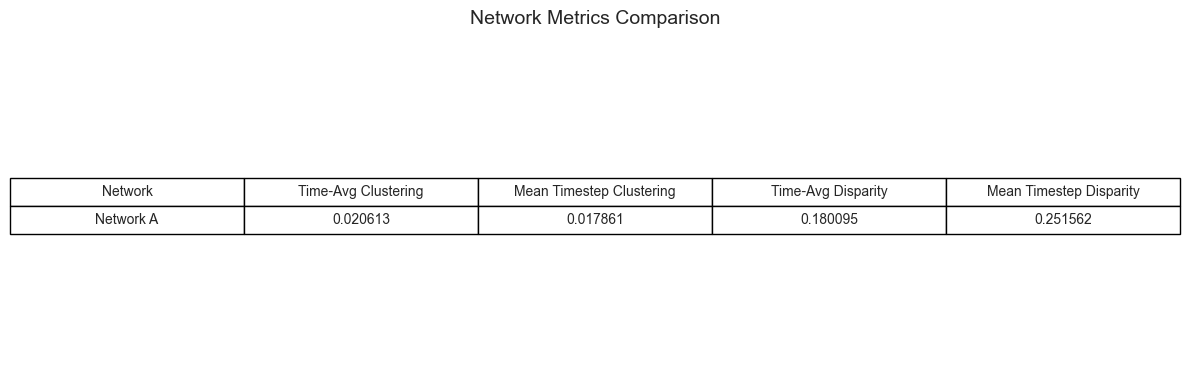

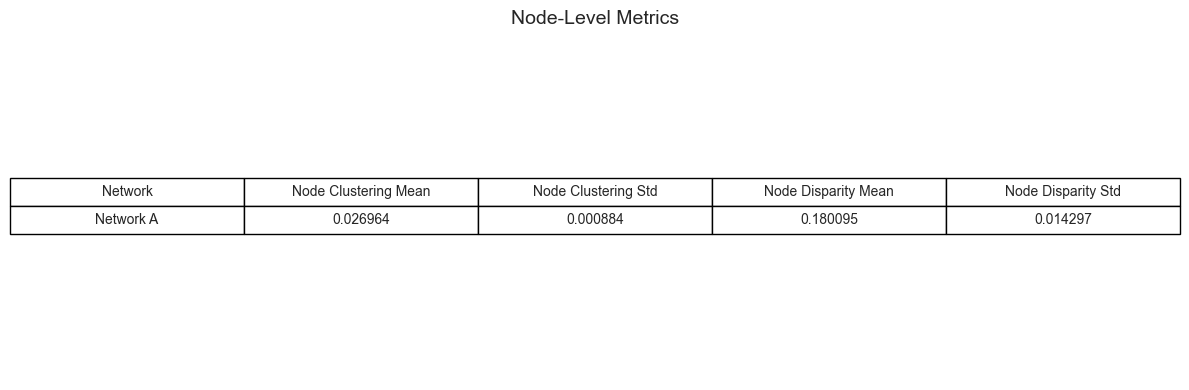

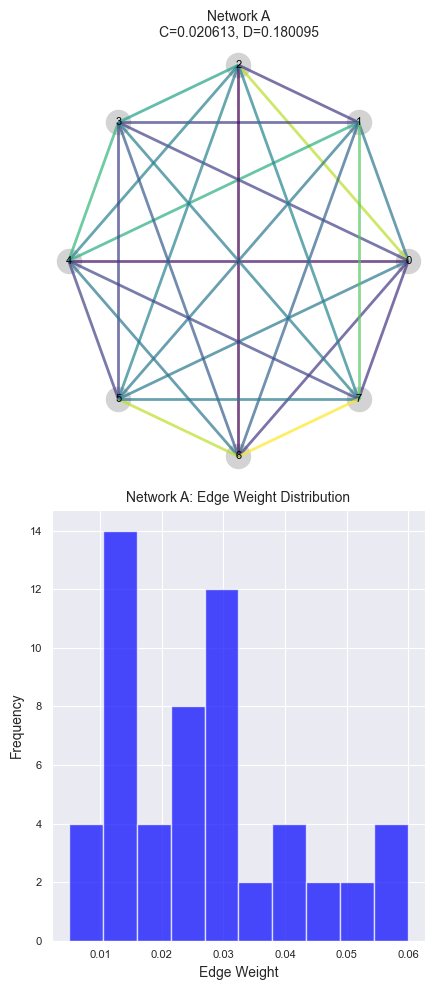

In [15]:
start =95
end=99
network_list = [
    MI_adj[m][0][start:end],  # Time series for Network 1
]

network_names = ["Network A"]

results = analyze_multiple_temporal_networks(network_list, network_names)

/var/folders/bn/rlrcnzv54rz0phyhcbjh1x4r0000gn/T/ipykernel_68776/2081472876.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


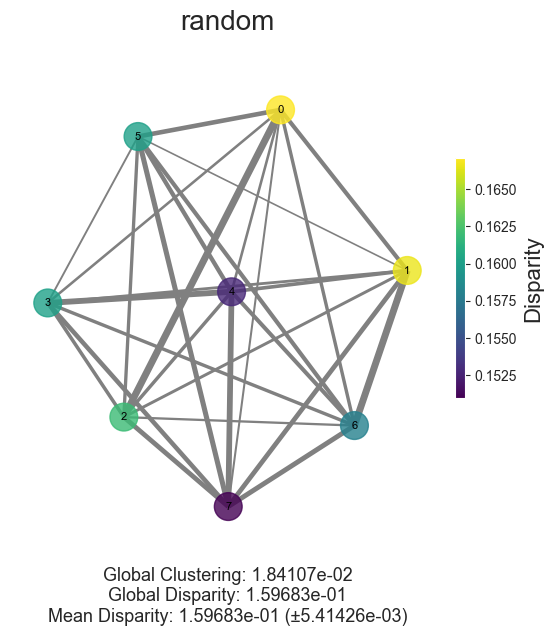

In [16]:
def disparity_per_node(adjacency_matrix):
    """Calculate disparity measure for each node in the graph using the provided formula"""
    adj_mat = np.array(adjacency_matrix)
    n_nodes = adj_mat.shape[0]
    node_disparity = {}

    for i in range(n_nodes):
        row_sum_squared = np.sum(adj_mat[i])**2
        row_sum_of_squared_elements = np.sum(adj_mat[i]**2)

        # Check for zero division
        if row_sum_squared == 0:
            node_disparity[i] = 0
        else:
            node_disparity[i] = row_sum_of_squared_elements / row_sum_squared

    return node_disparity

def clustering_coeff(adjacency_matrix_list):
    """Calculate global clustering coefficient for a list of adjacency matrices"""
    C_list = []
    for adj_mat in adjacency_matrix_list:
        adj_mat = np.array(adj_mat)
        M_sq = adj_mat @ adj_mat
        sum_of_M_sq = np.sum(M_sq)
        M_cube = adj_mat @ adj_mat @ adj_mat
        M_cube_trace = np.trace(M_cube)
        if sum_of_M_sq == 0:
            C_list.append(0)
        else:
            C_list.append(M_cube_trace / sum_of_M_sq)
    return np.array(C_list)

def disparity_function(adjacency_matrix_list, N):
    """Calculate global disparity for a list of adjacency matrices"""
    D_list = []
    for adj_mat in adjacency_matrix_list:
        M_row_sum_squared = np.sum(adj_mat, axis=1)**2
        M_row_sum_of_squared_elements = np.sum(adj_mat**2, axis=1)
        # Check for zero division before performing division
        Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)
        D_list.append(np.sum(Di) / N)
    return np.array(D_list)

def clustering_per_node(adjacency_matrix):
    """Calculate clustering coefficient for each node using the provided formula"""
    adj_mat = np.array(adjacency_matrix)
    n_nodes = adj_mat.shape[0]
    node_clustering = {}

    # Create a networkx graph to use for node-specific calculations
    G = nx.from_numpy_array(adj_mat)

    for i in range(n_nodes):
        neighbors = list(G.neighbors(i))
        if len(neighbors) <= 1:
            node_clustering[i] = 0.0
            continue

        triangles = 0
        possible_triangles = len(neighbors) * (len(neighbors) - 1) / 2

        if possible_triangles == 0:
            node_clustering[i] = 0.0
            continue

        # Count triangles for this node
        for j in neighbors:
            for k in neighbors:
                if j < k and G.has_edge(j, k):
                    triangles += 1

        node_clustering[i] = triangles / possible_triangles

    return node_clustering

def visualize_multiple_networks(datasets, dataset_names=None):
    """
    Visualize multiple temporal networks using representative network method

    Parameters:
    datasets: list of lists of adjacency matrices, each representing a temporal network
    dataset_names: optional list of names for the datasets

    Returns:
    Dictionary with metrics for each dataset and method
    """
    if dataset_names is None:
        dataset_names = [f"R {i+1}" for i in range(len(datasets))]

    n_datasets = len(datasets)

    # First pass: calculate all disparity values to determine global min/max
    all_node_disparity = []
    rep_matrices = []

    for dataset in datasets:
        # Calculate representative matrix
        n_timepoints = len(dataset)
        late_period = int(n_timepoints * 0.25)
        rep_matrix = np.mean(dataset[-late_period:], axis=0)
        rep_matrices.append(rep_matrix)

        # Calculate disparity for each node
        node_disparity_values = list(disparity_per_node(rep_matrix).values())
        all_node_disparity.extend(node_disparity_values)

    # Determine global min and max disparity values
    global_min_disparity = min(all_node_disparity)
    global_max_disparity = max(all_node_disparity)

    # Create a figure with 1 row and n_datasets columns
    fig = plt.figure(figsize=(5*n_datasets, 6))
    gs = GridSpec(1, n_datasets, figure=fig)

    # Store metrics for all datasets
    all_metrics = {name: {} for name in dataset_names}

    # For each dataset, create a representative network
    for col, (dataset, name, rep_matrix) in enumerate(zip(datasets, dataset_names, rep_matrices)):
        # Create subplot
        ax = fig.add_subplot(gs[0, col])

        # Generate representative network with global disparity range
        rep_matrix, G_rep, metrics = create_representative_network(
            dataset,
            rep_matrix=rep_matrix,
            ax=ax,
            title=f"{name}\n",
            global_min_disparity=global_min_disparity,
            global_max_disparity=global_max_disparity
        )

        # Store metrics
        all_metrics[name] = metrics

    # Add a single colorbar for the entire figure
    cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                             norm=plt.Normalize(vmin=global_min_disparity,
                                              vmax=global_max_disparity))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('Disparity',fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.05, right=0.9, hspace=0.3)
    #plt.savefig('MI_12_Q_therm_all_rules_spring_network_c4.png', bbox_inches='tight', pad_inches=0.5, dpi=300)
    plt.show()

    # Print summary metrics
    #print("\nSummary Metrics:")
    #for name in dataset_names:
    #    print(f"\n{name}:")
    #    metrics = all_metrics[name]
    #    for key, value in metrics.items():
    #        print(f"    - {key}: {value}")

    return all_metrics

def create_representative_network(time_matrices, ax=None, title=None, rep_matrix=None,
                            global_min_disparity=None, global_max_disparity=None):
    """
    Create and visualize a representative network from time-evolving data

    Parameters:
    time_matrices: list of adjacency matrices over time
    ax: matplotlib axis for plotting (if None, creates a new figure)
    title: title for the plot
    rep_matrix: pre-computed representative matrix (if None, it will be calculated)
    global_min_disparity: minimum disparity value for color normalization
    global_max_disparity: maximum disparity value for color normalization

    Returns:
    Representative adjacency matrix, networkx graph, and metrics
    """
    n_timepoints = len(time_matrices)
    n_nodes = time_matrices[0].shape[0]

    # Calculate representative matrix if not provided
    if rep_matrix is None:
        # Calculate representative matrix - using last 20% of time points
        late_period = int(n_timepoints * 0.2)
        rep_matrix = np.mean(time_matrices[-late_period:], axis=0)

    # Create a new figure if needed
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()

    # Create networkx graph
    G_rep = nx.from_numpy_array(rep_matrix)

    # Edge weights for thickness
    edges = G_rep.edges()
    edge_weights = nx.get_edge_attributes(G_rep, 'weight')
    if edge_weights:
        max_weight = max(edge_weights.values()) if edge_weights else 1.0
        weights = [G_rep[u][v]['weight'] * 5.0 / max_weight for u, v in edges]
    else:
        weights = [1.0] * len(edges)

    # Node sizes (fixed)
    node_sizes = [400] * n_nodes

    # Calculate clustering coefficient for each node using provided formula
    node_clustering = list(clustering_per_node(rep_matrix).values())

    # Calculate disparity for each node using provided formula
    node_disparity = list(disparity_per_node(rep_matrix).values())

    # Position nodes
    pos = nx.spring_layout(G_rep, weight='weight', k=0.3, iterations=300, seed=42)

    # Draw the network with disparity coloring
    # Use global min/max disparity values if provided, otherwise use local values
    if global_min_disparity is not None and global_max_disparity is not None:
        vmin, vmax = global_min_disparity, global_max_disparity
    else:
        vmin, vmax = min(node_disparity), max(node_disparity)

    nodes = nx.draw_networkx_nodes(G_rep, pos,
                                  node_size=node_sizes,
                                  node_color=node_disparity,
                                  cmap=plt.cm.viridis,
                                  vmin=vmin,
                                  vmax=vmax,
                                  alpha=0.8,
                                  ax=ax)

    # Individual colorbar is skipped - we'll add a global one later

    # Draw edges with varying thickness
    edges = nx.draw_networkx_edges(G_rep, pos,
                                  width=weights,
                                  edge_color='gray',
                                  alpha=1,
                                  ax=ax)

    # Draw labels for smaller networks
    if n_nodes <= 10:
        nx.draw_networkx_labels(G_rep, pos, font_size=8, ax=ax)

    # Calculate key metrics for the representative network
    metrics = {}

    # Basic network metrics
    metrics['density'] = nx.density(G_rep)
    metrics['num_edges'] = G_rep.number_of_edges()

    # Global clustering using the provided formula
    metrics['global_clustering'] = clustering_coeff([rep_matrix])[0]

    # Global disparity using the provided formula
    n_nodes = rep_matrix.shape[0]
    metrics['global_disparity'] = disparity_function([rep_matrix], n_nodes)[0]

    # Node-level metrics
    metrics['mean_clustering'] = np.mean(node_clustering)
    metrics['std_clustering'] = np.std(node_clustering)

    # Disparity metrics
    metrics['mean_disparity'] = np.mean(node_disparity)
    metrics['std_disparity'] = np.std(node_disparity)

    try:
        if nx.is_connected(G_rep):
            metrics['avg_path_length'] = nx.average_shortest_path_length(G_rep, weight='weight')
        else:
            # Calculate for largest connected component
            gcc = max(nx.connected_components(G_rep), key=len)
            metrics['avg_path_length'] = nx.average_shortest_path_length(
                G_rep.subgraph(gcc), weight='weight')
    except:
        metrics['avg_path_length'] = 'N/A'

    # Display mean and std of clustering and disparity under the graph
    if title:
        ax.set_title(title, fontsize=20)

    # Add text with metrics below the graph
    plt.text(0.5, -0.1,
             f"Global Clustering: {metrics['global_clustering']:.5e}\n"
             f"Global Disparity: {metrics['global_disparity']:.5e}\n"
             #f"Mean Clustering: {metrics['mean_clustering']:.6e} (±{metrics['std_clustering']:.6e})\n"
             f"Mean Disparity: {metrics['mean_disparity']:.5e} (±{metrics['std_disparity']:.5e})",
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=13,
             bbox=dict(facecolor='white', alpha=0.9))

    ax.axis('off')


    return rep_matrix, G_rep, metrics


m=2
start =10
end=99
network_list = [
    MI_adj[m][0][start:end],  # Time series for Network
]

network_names = [order_rule_name]

all_metrics = visualize_multiple_networks(network_list, dataset_names=network_names)